The training process is to train a neural network in a manner of supervised learning process using a convolutional neural network architecture. 

The network classifies whether the url string is beningn or malicious based on the url String.

In [1]:
# Package Imports
import pandas as pd
import numpy as np
from string import printable
from sklearn import model_selection
from keras.preprocessing import sequence
from keras.layers.core import Dropout, Dense
from keras import regularizers
from keras.layers import Input, Embedding, Convolution1D, ELU, MaxPooling1D, LSTM
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# Importing dataset
dataset = pd.read_csv('./dataset/urlString.csv')

In [3]:
dataset.head(20)

,url,isMalicious
0,songlyrics.com/news/riffd-the-shins-heartworms,0
1,imaging-resource.com/PRODS/olympus-e-m1-ii/oly...,0
2,gosugamers.net/lol/streams,0
3,thingiverse.com/corkyzett/collections/intlwome...,0
4,bausch.com/our-products/contact-lens-care/spec...,0
5,w88mobile.org/game/5151.html,0
6,datacenterdynamics.com/awards/latin-america-aw...,0
7,123people.com/s/marc+pageau,0
8,nownews.com/n/2017/03/21/2449327,0
9,wikipedia.org/wiki/Plague_Park,0


In [14]:
dataset = dataset.drop_duplicates()

In [15]:
len(dataset)

425135

In [16]:
# List of printable characters
printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [17]:
# dataset preparation
# encode the printable characters in the url string as integers
def urlPrep(url):
    return [printable.index(char) + 1 for char in url if char in printable]

In [18]:
url_tokens = []
for url in dataset.url:
    url_tokens.append(urlPrep(url))

In [19]:
# Standardize the url string length in the dataset taking only the first 75 printable characters or padding with zeros
max_length = 75
url_data = sequence.pad_sequences(url_tokens, maxlen=max_length)

In [20]:
# target_label array
target_label = np.array(dataset.isMalicious)

In [21]:
# Shape of the encoded url string array
url_data.shape

(425135, 75)

In [22]:
# Shape of the target labels array
target_label.shape

(425135,)

In [23]:
# splitting the url dataset using 25 percent for testing
url_train, url_test, target_train, target_test = model_selection.train_test_split(url_data, target_label, test_size=0.25, random_state=30)

In [24]:
def lstm_conv(max_len=75, emb_dim=32, max_vocab_len=100, lstm_output_size=32, W_reg=regularizers.l2(1e-4)):
    # Input
    main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
    # Embedding layer
    emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
                W_regularizer=W_reg)(main_input) 
    emb = Dropout(0.25)(emb)

    # Conv layer
    conv = Convolution1D(kernel_size=5, filters=256, \
                     border_mode='same')(emb)
    conv = ELU()(conv)

    conv = MaxPooling1D(pool_size=4)(conv)
    conv = Dropout(0.5)(conv)

    # LSTM layer
    lstm = LSTM(lstm_output_size)(conv)
    lstm = Dropout(0.5)(lstm)
    
    # Output layer (last fully connected layer)
    output = Dense(1, activation='sigmoid', name='output')(lstm)

    # Compile model and define optimizer
    model = Model(input=[main_input], output=[output])
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [25]:
epochs = 7
batch_size = 30

model = lstm_conv()
history = model.fit(url_train, target_train, epochs=epochs, batch_size=batch_size)
loss, accuracy = model.evaluate(url_test, target_test, verbose=1)

print('\nFinal Cross-Validation Accuracy', accuracy, '\n')

/anaconda3/envs/url/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=100, output_dim=32, input_length=75, embeddings_regularizer=<keras.reg...)`
  
/anaconda3/envs/url/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=5, filters=256, padding="same")`
  # This is added back by InteractiveShellApp.init_path()


Instructions for updating:
Use tf.cast instead.


/anaconda3/envs/url/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


Epoch 1/7
318851/318851 [==============================] - 487s 2ms/step - loss: 0.2129 - acc: 0.9131
Epoch 2/7
318851/318851 [==============================] - 447s 1ms/step - loss: 0.1512 - acc: 0.9435
Epoch 3/7
318851/318851 [==============================] - 426s 1ms/step - loss: 0.1370 - acc: 0.9499
Epoch 4/7
318851/318851 [==============================] - 422s 1ms/step - loss: 0.1274 - acc: 0.9542
Epoch 5/7
318851/318851 [==============================] - 446s 1ms/step - loss: 0.1204 - acc: 0.9573
Epoch 6/7
318851/318851 [==============================] - 444s 1ms/step - loss: 0.1158 - acc: 0.9593
Epoch 7/7
106284/106284 [==============================] - 34s 320us/step

Final Cross-Validation Accuracy 0.9663354785292236 



In [26]:
import matplotlib.pyplot as plt

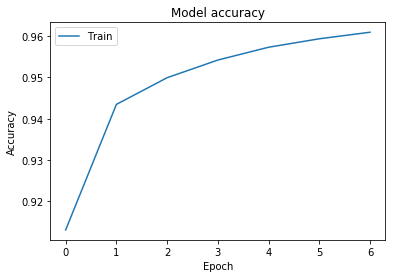

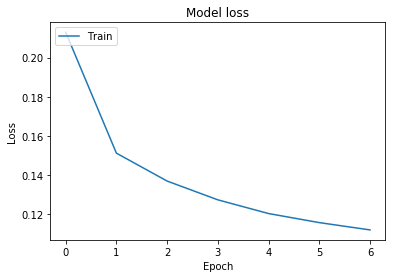

In [28]:
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [68]:
model.save_weights('model_convolutional.h5')

In [6]:
model = lstm_conv()
model.load_weights('model_convolutional.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/anaconda3/envs/url/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=100, output_dim=32, input_length=75, embeddings_regularizer=<keras.reg...)`
  
/anaconda3/envs/url/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=5, filters=256, padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/envs/url/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [11]:
import pydot
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [70]:
test_url_mal = "naureen.net/etisalat.ae/index2.php"
test_url_benign = "sixt.com/php/reservation?language=en_US"

url = "www.google.co.in/sfdghgm"

In [71]:
url_int_tokens = [[printable.index(x) + 1 for x in test_url_benign if x in printable]]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=75
X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)

In [72]:
target_proba = model.predict(X, batch_size=1)
def print_result(proba):
    if proba > 0.5:
        return "malicious"
    else:
        return "benign"
print("Test URL:", url, "is", print_result(target_proba[0]))

Test URL: www.google.co.in/sfdghgm is benign
